0. Package Import and Data Loading
1. Feature engineering
2. Variable correlation
3. Removing outliers
4. Pickling

## 0. Import packages
Load the necessary packages for this exercise

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

In [4]:
#show plots in jupyter notebook
%matplotlib inline

In [5]:
# Set plot style
sns.set(color_codes=True)

In [6]:
#Set maximum number of columns to be displayed
pd.set_option('display.max_columns',100)

## Loading data
### Data directory
Explicitly show how paths are indicated

In [12]:
PICKLE_TRAIN_DIR=os.path.join(".","processed_data","train_data.pkl")
PICKLE_HISTORY_DIR=os.path.join(".","processed_data","history_data.pkl")

In [13]:
history_data = pd.read_pickle(PICKLE_HISTORY_DIR) 
train = pd.read_pickle(PICKLE_TRAIN_DIR)

## 1. Feature Engineering
Since we have the consumption data for each of the companies for the year 2015, we will create new features using the average of the year, the last six months, and the last three months to our model.

In [30]:
history_data['price_date'].value_counts()

2015-08-01    16094
2015-12-01    16094
2015-07-01    16090
2015-11-01    16087
2015-06-01    16085
2015-10-01    16085
2015-02-01    16082
2015-09-01    16082
2015-05-01    16080
2015-04-01    16079
2015-03-01    16074
2015-01-01    16070
Name: price_date, dtype: int64

In [22]:
mean_year=history_data.groupby(['id']).mean().reset_index()

In [28]:
mean_6m=history_data[history_data['price_date']>'2015-06-01'].groupby(['id']).mean().reset_index()

In [31]:
mean_3m=history_data[history_data['price_date']>'2015-10-01'].groupby(['id']).mean().reset_index()

In [32]:
mean_year.head(3)

,id,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.00000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.00000,45.319710,0.000000,0.000000


In [33]:
###Combine them in a single dataframe
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var", "price_p2_var": "mean_year_price_p2_var", "price_p3_var": "mean_year_price_p3_var", "price_p1_fix": "mean_year_price_p1_fix", "price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",}) 
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"] 
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"] 
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [34]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var", "price_p2_var": "mean_6m_price_p2_var", "price_p3_var": "mean_6m_price_p3_var", "price_p1_fix": "mean_6m_price_p1_fix", "price_p2_fix": "mean_6m_price_p2_fix",
"price_p3_fix": "mean_6m_price_p3_fix",}) 
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"] 
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"] 
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

In [35]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var", "price_p2_var": "mean_3m_price_p2_var", "price_p3_var": "mean_3m_price_p3_var", "price_p1_fix": "mean_3m_price_p1_fix", "price_p2_fix": "mean_3m_price_p2_fix",
"price_p3_fix": "mean_3m_price_p3_fix",}) 
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"] 
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"] 
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]

Now we will merge them into a single dataframe
Note: I am not confident the mean_6m and mean_3m could help the prediction model. We will see below the variables are also highly correlated to
actually using only the mean_year is OK

In [37]:
#features = pd.merge(mean_year,mean_6m, on="id").merge(mean_3m,on='id')
features=mean_year

### 2. churn by dates variabls
In the previous notebook we explored the data and made a deep dive into the churn by dates. Nonetheless, that exploration was quite shallow and did not provide us with any relevant insight.
What if we could create a new variable that could provide us more relevant insights? We will define a variable tenure = date_end - date_activ

In [51]:
train['tenure']=((train['date_end']-train['date_activ'])/ np.timedelta64(1, "Y")).astype(int)

In [58]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1) 
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

In [59]:
tenure

churn,0,1
tenure,,
0,1.0,NaN
2,262.0,40.0
3,1178.0,193.0
4,3632.0,535.0
5,3010.0,297.0
6,3052.0,269.0
7,2649.0,210.0
8,162.0,11.0
9,94.0,2.0


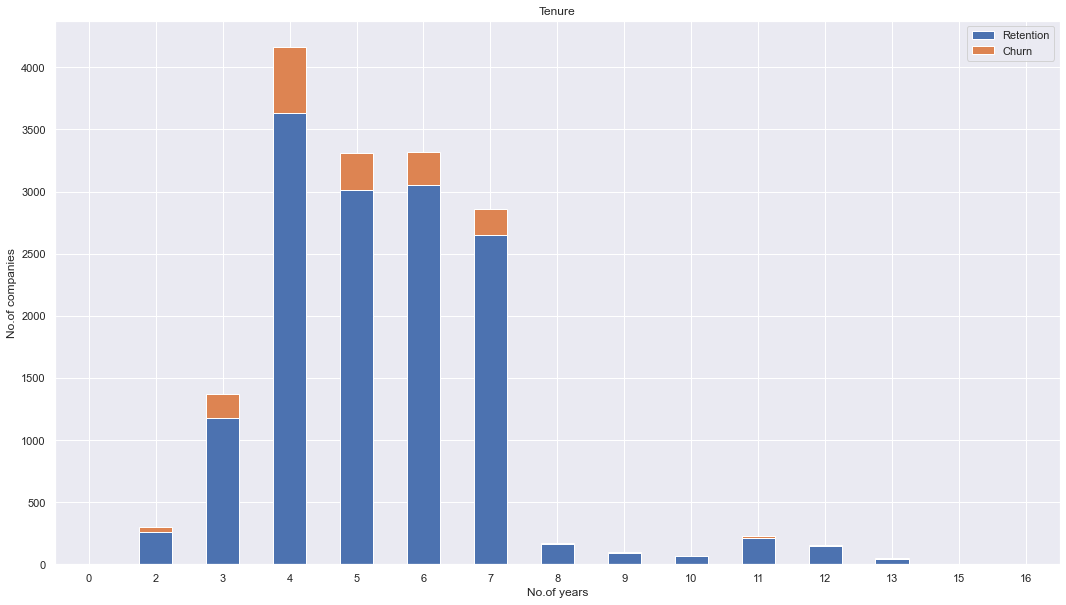

In [60]:
tenure.plot(kind='bar',figsize=(18,10),stacked=True,rot=0,title='Tenure')
#Rename legend
plt.legend(['Retention','Churn'],loc='upper right')
#Labels
_=plt.ylabel('No.of companies')
_=plt.xlabel('No.of years')
plt.show()

We can clearly that churn is very low for companies which joined recently or that have made the contract a long time ago. With the higher number of churners within the 3-7 years of tenure.

We will also transform the dates provided in such a way that we can make more sense out of those. 
months_activ : Number of months active until reference date (Jan 2016)

months_to_end : Number of months of the contract left at reference date (Jan 2016)

months_modif_prod : Number of months since last modification at reference date (Jan 2016)

months_renewal : Number of months since last renewal at reference date (Jan 2016)

To create the month column we will follow a simple process:
   1. Substract the reference date and the column date
   2. Convert the timedelta in months
   3. Convert to integer (we are not interested in having decimal months)

In [66]:
def convert_months(reference_date,dataframe,column):
    """
    Input a column with timedeltas and return months
    """
    time_delta=reference_date-dataframe[column]
    months=(time_delta/np.timedelta64(1,'M')).astype(int)
    return months

In [63]:
REFERENCE_DATE=datetime.datetime(2016,1,1)

In [68]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ") 
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end") 
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod") 
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

In [ ]:
def plot_churn_by_month(dataframe,column,fontsize_=11):
    """
    Plot churn distribution by monthly variable
    """
    